In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

In [2]:
wd = os.getcwd()

# Define Functions

In [3]:
class RunResult:
    """
    Results files in order:
    Forward-looking horizon: int
    actions: n by 4 dataframe
    storage levels: n by 1 series
    profit: n by 1 series
    price: n by 1 series, true prices
    shape: n by 1 series, true shape
    total_profit: sum of profit
    """ 
    def __init__(self, gb, bg, b, profits, price, day_index):
        self.charging = gb
        self.discharging = bg
        self.storage_levels = b
        self.profit = profits
        self.price = price
        self.total_profit = sum(profits)
        self.day_index = day_index

    def plot_states_actions(self, start=None, hourrange=None):
        """
        if start = hourrange = None, plot all series; otherwise a slice of the data
        """
        if start == hourrange == None:
            hourrange = len(self.storage_levels)
            start = 0

        hr = range(0, start + hourrange)

        # price, profit, storage level, solar gen
        sns.reset_orig()

        fig, ax1 = plt.subplots(figsize=(16, 8))

        ax1.plot(hr, self.price[start:start + hourrange], label="price", color='blue')

        ax2 = ax1.twinx()
        ax2.plot(hr, self.storage_levels[start:start + hourrange], label="storage level", color='g')

        ax1.set_xlabel('Hour')
        ax1.set_ylabel('price')
        ax2.set_ylabel('storage level')

        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        ax1.grid('both', axis='both', color='grey', linestyle="--")
        plt.xticks(np.arange(0, hourrange, 10))

        plt.show()

        print("Total profit: ${0:.2f}".format(self.total_profit))

        # actions
        colormap = ['violet', 'darkviolet']

        fig, ax = plt.subplots(figsize=(16, 8))
        ax.stackplot(hr, -self.discharging, self.charging, labels=['discharging', 'charging'], colors=colormap)
        ax.set_xlabel('Hour')
        ax.set_ylabel('storage operation decisions')
        ax.legend()
        ax.grid('both', axis='both', color='grey', linestyle="--")
        plt.xticks(np.arange(0, hourrange, 5))
        plt.show()
        
def translate_results(raw_results):
    """
    function to translate raw results into RunResult classes
    """
    translated_results = []
    for i, result in enumerate(raw_results):
        try:
            rr = RunResult(*result[0],result[1])
            translated_results.append(rr)
        except:
            print(f"Error occurred in run {i}.")
    
    return translated_results

In [4]:
# Compare results between models
def results_comparison(name_1, results_1, name_2, results_2):
    # Match DP and MPC results based on day_index
    rslt1_dict = {rr.day_index: rr.total_profit for rr in results_1}
    rslt2_dict = {rr.day_index: rr.total_profit for rr in results_2}
    matched_indices = set(rslt1_dict.keys()) & set(rslt2_dict.keys())
    
    matched_rslt1_profits = [rslt1_dict[idx] for idx in matched_indices]
    matched_rslt2_profits = [rslt2_dict[idx] for idx in matched_indices]
    
    # Calculate average profits for matched cases
    rslt1_avg = np.mean(matched_rslt1_profits)
    rslt2_avg = np.mean(matched_rslt2_profits)
    
    print(f"Average profit for {name_1}: ${rslt1_avg:.2f}")
    print(f"Average profit for {name_2}: ${rslt2_avg:.2f}")

    # Scatter plot of profits for matched cases
    plt.scatter(matched_rslt1_profits, matched_rslt2_profits)
    plt.xlabel(f"Matched {name_1} profits")
    plt.ylabel(f"Matched {name_2} profits")
    plt.title(f"Scatter Plot of Matched {name_1} and {name_2} Profits")
    # add the 45 degree line
    plt.plot([min(matched_rslt1_profits + matched_rslt2_profits), max(matched_rslt1_profits + matched_rslt2_profits)], 
         [min(matched_rslt1_profits + matched_rslt2_profits), max(matched_rslt1_profits + matched_rslt2_profits)], 
         color='red', linestyle='--', linewidth=1)
    plt.show()

    # Histogram of profits for matched cases
    plt.hist(matched_rslt1_profits, alpha=0.5, label=name_1)
    plt.hist(matched_rslt2_profits, alpha=0.5, label=name_2)
    plt.xlabel("Profits")
    plt.ylabel("Frequency")
    plt.legend()
    plt.title(f"Histogram of Matched {name_1} and {name_2} Profits")
    plt.show()

    # Boxplot of profits for matched cases
    plt.boxplot([matched_rslt1_profits, matched_rslt2_profits], labels=[name_1, name_2])
    plt.ylabel("Profits")
    plt.title(f"Boxplot of Matched {name_1} and {name_2} Profits")
    plt.show()

In [5]:
# plot day index X for MPC, LP, DP and FB
def plot_one_day(day_index, mpc_results, lp_results, dp_results, fb_results):
    # look for corresponding index in these results
    for i, rr in enumerate(mpc_results):
        if rr.day_index == day_index:
            mpc_index = i
            break
    for i, rr in enumerate(lp_results):
        if rr.day_index == day_index:
            lp_index = i
            break
    for i, rr in enumerate(dp_results):
        if rr.day_index == day_index:
            dp_index = i
            break
    for i, rr in enumerate(fb_results):
        if rr.day_index == day_index:
            fb_index = i
            break
    # plot storage level and price
    hr = range(0, 4)
    fig, ax1 = plt.subplots(figsize=(16, 8))
    ax1.plot(hr, mpc_results[mpc_index].storage_levels, label="MPC storage level", color='blue', marker='o')
    ax1.plot(hr, lp_results[lp_index].storage_levels, label="LP storage level", color='red', marker='x')
    ax1.plot(hr, dp_results[dp_index].storage_levels, label="DP storage level", color='orange', marker='*')
    # ax1.plot(hr, fb_results[fb_index].storage_levels, label="FB storage level", color='purple', linestyle='--')
    ax2 = ax1.twinx()
    ax2.plot(hr, mpc_results[mpc_index].price, label="price", color='green')
    # ax2.plot(hr, managed_lp_results[lp_index].price, label="price", color='yellow')
    ax1.set_xlabel('Hour')
    ax1.set_ylabel('storage level')
    ax2.set_ylabel('price')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    ax1.grid('both', axis='both', color='grey', linestyle="--")
    # print profit in a text box
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # textstr = f"MPC profit: ${mpc_results[mpc_index].total_profit:.2f}\nLP profit: ${lp_results[lp_index].total_profit:.2f}\nDP profit: ${dp_results[dp_index].total_profit:.2f}\nFB profit: ${fb_results[fb_index].total_profit:.2f}"
    textstr = f"MPC profit: ${mpc_results[mpc_index].total_profit:.2f}\nLP profit: ${lp_results[lp_index].total_profit:.2f}\nDP profit: ${dp_results[dp_index].total_profit:.2f}\n"
    ax1.text(0.45, 0.15, textstr, transform=ax1.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.title(f"Day index {day_index}")
    plt.xticks(np.arange(0, 4, 5))
    plt.show()

In [6]:
## convert raw sequential results to daily results RunResult classes
def seq_to_runresult(raw_results):
    """
    function to translate raw results into RunResult classes
    """
    # first divide into days and then translate
    num_days = raw_results[0].shape[0]/4
    # slice all five FB_results into days, then repackage into a tuple of 5 tuples of arrays
    results_sequential = tuple(zip(*[np.split(raw_results[i], num_days) for i in range(5)]))
    # add day_index to each day
    results_sequential = [(results_sequential[i], i) for i in range(len(results_sequential))]
    # translate into RunResult classes
    results_sequential = translate_results(results_sequential)
    return results_sequential

# Import Results to Compare

In [68]:
FB_results_sequential_raw = pickle.load(open(wd + "\\Optimization_module\\test_results\\FB_sequential.pkl", "rb"))
LP_results_sequential_raw = pickle.load(open(wd + "\\Optimization_module\\test_results\\LP_sequential_800_20_0_[10, 10, 20, 20]_5_NoRandom.pkl", "rb"))
MPC_results_sequential_raw = pickle.load(open(wd + "\\Optimization_module\\test_results\\MPC_sequential_800_20_0_[10, 10, 20, 20]_5_NoRandom.pkl", "rb"))
DP_results_sequential_raw = pickle.load(open(wd + "\\Optimization_module\\test_results\\DP_sequential_800_20_0_[10, 10, 20, 20]_5_NoRandom.pkl", "rb"))

In [69]:
FB_results_sequential = seq_to_runresult(FB_results_sequential_raw)
LP_results_sequential = seq_to_runresult(LP_results_sequential_raw)
MPC_results_sequential = seq_to_runresult(MPC_results_sequential_raw)
DP_results_sequential = seq_to_runresult(DP_results_sequential_raw)

In [ ]:
## convert raw parallel results to RunResult classes
MPC_results = []
with open('Optimization_module/test_results/MPC_300_2023-10-31.pkl','rb') as file:
    try:
        while True:
            MPC_results.append(pickle.load(file))
    except EOFError:
        pass  # No more items to read

DP_results = []
with open('Optimization_module/test_results/DP_300_2023-10-31.pkl','rb') as file:
    try:
        while True:
            DP_results.append(pickle.load(file))
    except EOFError:
        pass  # No more items to read

LP_results = []
with open('Optimization_module/test_results/LP_300_2023-10-31.pkl','rb') as file:
    try:
        while True:
            LP_results.append(pickle.load(file))
    except EOFError:
        pass  # No more items to read

FB_results = []
with open('Optimization_module/test_results/FB_300_2023-11-09.pkl','rb') as file:
    try:
        while True:
            FB_results.append(pickle.load(file))
    except EOFError:
        pass  # No more items to read

In [ ]:
managed_dp_results = translate_results(DP_results)
managed_mpc_results = translate_results(MPC_results)
managed_lp_results = translate_results(LP_results)
managed_fb_results = translate_results(FB_results)

# Comparisons

In [ ]:
# double check that the results used the same set of day_index
dp_dict = {rr.day_index: rr.total_profit for rr in managed_dp_results}
mpc_dict = {rr.day_index: rr.total_profit for rr in managed_mpc_results}
lp_dict = {rr.day_index: rr.total_profit for rr in managed_lp_results}
fb_dict = {rr.day_index: rr.total_profit for rr in managed_fb_results}

print(set(dp_dict.keys()) == set(mpc_dict.keys()))
print(set(dp_dict.keys()) == set(lp_dict.keys()))
print(set(dp_dict.keys()) == set(fb_dict.keys()))

In [ ]:
# get set of day_index
day_indices = set(dp_dict.keys())

## Hypothesis Check

In [ ]:
#### Hypothesis 1: for FB sequential and FB parallel, the profits should roughly be the same
## 1.1: FB sequential always has b0=0 at the beginning of most days
## 1.2: for the sampled days in FB parallel, the profits should be the same as FB sequential

# 1.1
# get all b0 values for FB sequential
# since we are tracking end-of-period storage level, b0 is actually the storage level at the end of the previous day
end_b_values = [rr.storage_levels[-1] for rr in FB_results_sequential]
# find days when b0 is not 0
nonzero_endb = [i for i, b0 in enumerate(end_b_values) if b0 != 0]
print(f"FB sequential storage level=0 at the end of {len(nonzero_endb)} out of {len(FB_results_sequential)} days, or {len(nonzero_endb)/len(FB_results_sequential)*100:.2f}% of the days.")
# print the day indices when b0 is not 0
print(f"Day indices when end-of-day storage level is not 0: {nonzero_endb}")

In [ ]:
# the direct comparison between FB sequential (days matched to FB parallel) and FB parallel
# shows that the profits for FB parallel are lower than FB sequential
# this is because FB parallel has a nonzero b0 at the beginning of each day

# find the matched days in FB sequential results based on day_indices
matched_FB_sequential = [rr for rr in FB_results_sequential if rr.day_index in day_indices]
results_comparison("FB sequential", matched_FB_sequential, "FB parallel", managed_fb_results)

In [ ]:
# when we exclude the days when end-of-day storage level is 0 and the following day
# the profits should be the same for FB sequential and FB parallel

# get the day indices for the days to exclude
exclude_days = nonzero_endb + [i+1 for i in nonzero_endb]
# get the day indices for the days to include
include_days = list(day_indices - set(exclude_days))
# filtered FB sequential results
filtered_FB_results_sequential = [rr for rr in FB_results_sequential if rr.day_index in include_days]
# filtered FB parallel results
filtered_FB_results = [rr for rr in managed_fb_results if rr.day_index in include_days]

In [ ]:
# 1.2
# compare profits between matched_FB_sequential and managed_fb_results
results_comparison("FB_sequential", filtered_FB_results_sequential, "FB_parallel", filtered_FB_results)

In [ ]:
#### Hypothesis 2: DP should never underperform LP
# loop through DP and LP total profit, find the cases where DP < LP
dp_lp = []
for i in day_indices:
    if dp_dict[i] - lp_dict[i] < -1e-6:
        dp_lp.append(i)
print(f"DP < LP: {dp_lp}")
print(f"Out of {len(day_indices)} days, DP < LP for {len(dp_lp)} days, or {len(dp_lp)/len(day_indices)*100:.2f}% of the days.")
dp_lp = []
for i in day_indices:
    if dp_dict[i] - lp_dict[i] > 1e-6:
        dp_lp.append(i)
print(f"DP > LP: {dp_lp}")
print(f"Out of {len(day_indices)} days, DP > LP for {len(dp_lp)} days, or {len(dp_lp)/len(day_indices)*100:.2f}% of the days.")

Day 58 is likely due to the discretization in DP algorithm.

In [ ]:
# for day index = 5, plot storage level of DP and LP on the same plot, as well as the price
day_index = 18
# look for corresponding index in DP and LP results
for i, rr in enumerate(managed_dp_results):
    if rr.day_index == day_index:
        dp_index = i
        break
for i, rr in enumerate(managed_lp_results):
    if rr.day_index == day_index:
        lp_index = i
        break
# plot storage level and price
hr = range(0, 24)
fig, ax1 = plt.subplots(figsize=(16, 8))
ax1.plot(hr, managed_dp_results[dp_index].storage_levels, label="DP storage level", color='blue')
ax1.plot(hr, managed_lp_results[lp_index].storage_levels, label="LP storage level", color='red')
ax2 = ax1.twinx()
ax2.plot(hr, managed_dp_results[dp_index].price, label="price", color='green')
ax2.plot(hr, managed_lp_results[lp_index].price, label="price", color='yellow')
ax1.set_xlabel('Hour')
ax1.set_ylabel('storage level')
ax2.set_ylabel('price')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax1.grid('both', axis='both', color='grey', linestyle="--")
plt.xticks(np.arange(0, 24, 5))
plt.show()

In [ ]:
#### Hypothesis 3: FB parallel should never underperform DP, LP, or MPC
# loop through FB and DP total profit, find the cases where FB < DP
fb_dp = []
for i in day_indices:
    if fb_dict[i] - dp_dict[i] < -1e-6:
        fb_dp.append(i)
print(f"FB < DP: {fb_dp}")
print(f"Out of {len(day_indices)} days, FB < DP for {len(fb_dp)} days, or {len(fb_dp)/len(day_indices)*100:.2f}% of the days.")
# loop through FB and LP total profit, find the cases where FB < LP
fb_lp = []
for i in day_indices:
    if fb_dict[i] - lp_dict[i] < -1e-6:
        fb_lp.append(i)
print(f"FB < LP: {fb_lp}")
print(f"Out of {len(day_indices)} days, FB < LP for {len(fb_lp)} days, or {len(fb_lp)/len(day_indices)*100:.2f}% of the days.")
# loop through FB and MPC total profit, find the cases where FB < MPC
fb_mpc = []
for i in day_indices:
    if fb_dict[i] - mpc_dict[i] < -1e-6:
        fb_mpc.append(i)
print(f"FB < MPC: {fb_mpc}")
print(f"Out of {len(day_indices)} days, FB < MPC for {len(fb_mpc)} days, or {len(fb_mpc)/len(day_indices)*100:.2f}% of the days.")

## Compare Models

### Comparison between sequential & sample models

In [ ]:
# total profit of LP sequential and LP parallel
# first filter for the days that are in both LP sequential and LP parallel
# then compare profits

matched_LP_sequential = [rr for rr in LP_results_sequential if rr.day_index in day_indices]
results_comparison("LP sequential", matched_LP_sequential, "FB parallel", managed_lp_results)

In [ ]:
matched_MPC_sequential = [rr for rr in MPC_results_sequential if rr.day_index in day_indices]
results_comparison("LP sequential", matched_MPC_sequential, "FB parallel", managed_mpc_results)

In [ ]:
matched_DP_sequential = [rr for rr in DP_results_sequential if rr.day_index in day_indices]
results_comparison("DP sequential", matched_DP_sequential, "FB parallel", managed_dp_results)

### Overall performance comparison

In [70]:
########## for sequential models
# compare avg daily profits for DP, LP, MPC, FB
fb_avg_seq = np.mean([rr.total_profit for rr in FB_results_sequential])
dp_avg_seq = np.mean([rr.total_profit for rr in DP_results_sequential])
lp_avg_seq = np.mean([rr.total_profit for rr in LP_results_sequential])
mpc_avg_seq = np.mean([rr.total_profit for rr in MPC_results_sequential])
# compute profit percentage delta relative to FB
fb_dp_seq_delta = (fb_avg_seq - dp_avg_seq)/fb_avg_seq
fb_lp_seq_delta = (fb_avg_seq - lp_avg_seq)/fb_avg_seq
fb_mpc_seq_delta = (fb_avg_seq - mpc_avg_seq)/fb_avg_seq
print(f"DP profit is {fb_dp_seq_delta*100:.4f}% lower than FB profit.")
print(f"LP profit is {fb_lp_seq_delta*100:.4f}% lower than FB profit.")
print(f"MPC profit is {fb_mpc_seq_delta*100:.4f}% lower than FB profit.")

DP profit is 32.8569% lower than FB profit.
LP profit is 33.4753% lower than FB profit.
MPC profit is 33.4753% lower than FB profit.


In [ ]:
########## for sampled days
# compare avg daily profits between FB parallel and DP, LP, MPC
fb_avg = np.sum([rr.total_profit for rr in managed_fb_results])
dp_avg = np.sum([rr.total_profit for rr in managed_dp_results])
lp_avg = np.sum([rr.total_profit for rr in managed_lp_results])
mpc_avg = np.sum([rr.total_profit for rr in managed_mpc_results])
# compute profit percentage delta using FB as baseline
dp_delta = (dp_avg - fb_avg)/fb_avg
lp_delta = (lp_avg - fb_avg)/fb_avg
mpc_delta = (mpc_avg - fb_avg)/fb_avg
print(f"DP profit is {dp_delta*100:.4f}% higher than FB profit.")
print(f"LP profit is {lp_delta*100:.4f}% higher than FB profit.")
print(f"MPC profit is {mpc_delta*100:.4f}% higher than FB profit.")

In [62]:
dp_avg_seq

-2.926069519598136

In [61]:
lp_avg_seq

-3.6125757604605493

In [71]:
(dp_avg_seq - lp_avg_seq)/abs(lp_avg_seq)*100

0.9295928597010963

### Why is MPC worse than LP?

In [ ]:
results_comparison("MPC", managed_mpc_results, "LP", managed_lp_results)

In [ ]:
# Find days when MPC < LP
mpc_lp = []
for i in day_indices:
    if mpc_dict[i] - lp_dict[i] < -1e-6:
        mpc_lp.append(i)
print(f"MPC < LP: {mpc_lp}")
print(f"Out of {len(day_indices)} days, MPC < LP for {len(mpc_lp)} days, or {len(mpc_lp)/len(day_indices)*100:.2f}% of the days.")

# Find days when MPC > LP
mpc_lp = []
for i in day_indices:
    if mpc_dict[i] - lp_dict[i] > 1e-6:
        mpc_lp.append(i)
print(f"MPC > LP: {mpc_lp}")
print(f"Out of {len(day_indices)} days, MPC > LP for {len(mpc_lp)} days, or {len(mpc_lp)/len(day_indices)*100:.2f}% of the days.")

In [ ]:
plot_one_day(57, managed_mpc_results, managed_lp_results, managed_dp_results, managed_fb_results)

In [ ]:
plot_one_day(58, managed_mpc_results, managed_lp_results, managed_dp_results, managed_fb_results)

### MPC vs. DP

In [ ]:
# find days where MPC < DP
mpc_dp = []
for i in day_indices:
    if mpc_dict[i] - dp_dict[i] < -1e-6:
        mpc_dp.append(i)
print(f"MPC < DP: {mpc_dp}")
print(f"Out of {len(day_indices)} days, MPC < DP for {len(mpc_dp)} days, or {len(mpc_dp)/len(day_indices)*100:.2f}% of the days.")

# find days where MPC > DP
mpc_dp = []
for i in day_indices:
    if mpc_dict[i] - dp_dict[i] > 1e-6:
        mpc_dp.append(i)
print(f"MPC > DP: {mpc_dp}")
print(f"Out of {len(day_indices)} days, MPC > DP for {len(mpc_dp)} days, or {len(mpc_dp)/len(day_indices)*100:.2f}% of the days.")

In [ ]:
plot_one_day(13)

### DP vs. LP

In [ ]:
# find days where DP > LP
dp_lp = []
for i in day_indices:
    if dp_dict[i] - lp_dict[i] > 1e-6:
        dp_lp.append(i)
print(f"DP > LP: {dp_lp}")
print(f"Out of {len(day_indices)} days, DP > LP for {len(dp_lp)} days, or {len(dp_lp)/len(day_indices)*100:.2f}% of the days.")

# find days where DP < LP
dp_lp = []
for i in day_indices:
    if dp_dict[i] - lp_dict[i] < -1e-6:
        dp_lp.append(i)
print(f"DP < LP: {dp_lp}")
print(f"Out of {len(day_indices)} days, DP < LP for {len(dp_lp)} days, or {len(dp_lp)/len(day_indices)*100:.2f}% of the days.")

In [ ]:
plot_one_day(119, managed_mpc_results, managed_lp_results, managed_dp_results, managed_fb_results)

In [72]:
lp_profits = [rr.total_profit for rr in LP_results_sequential]
dp_profits = [rr.total_profit for rr in DP_results_sequential]
# find the day index where the two profit values are different
for i in range(len(lp_profits)):
    if abs(lp_profits[i] - dp_profits[i]) > 1e-3:
        print(i)

66


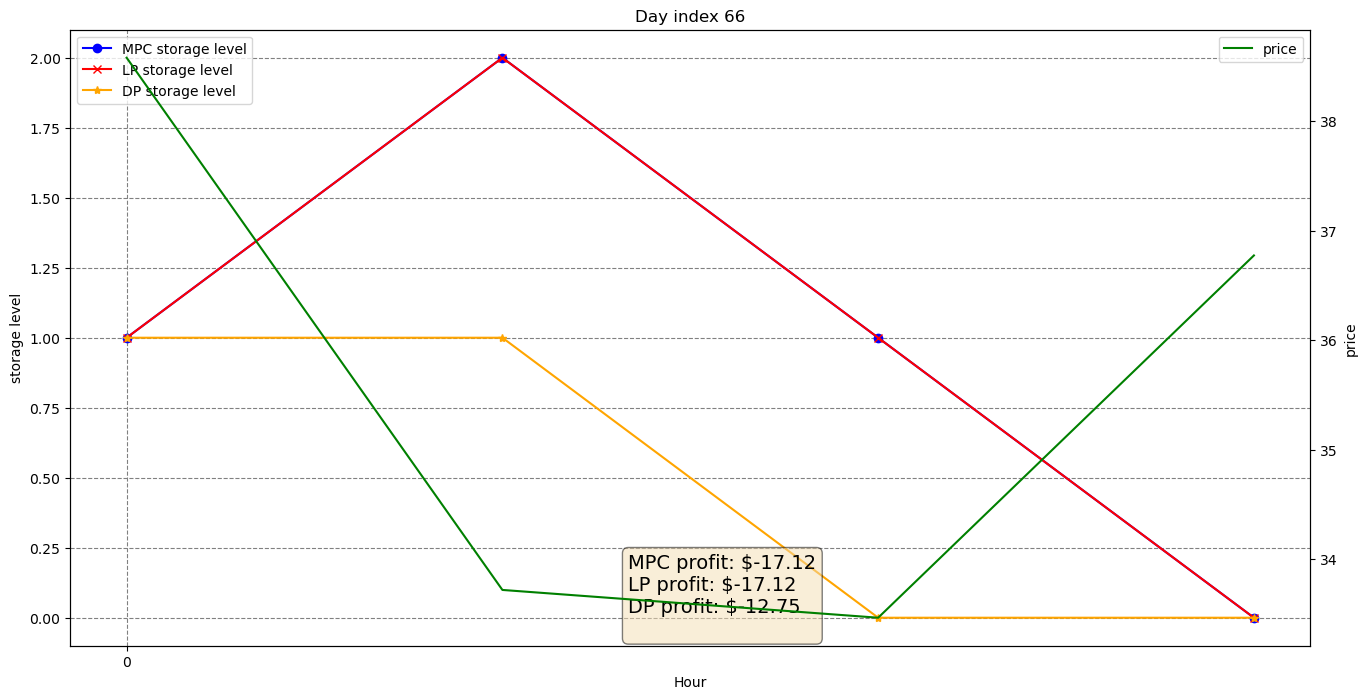

In [73]:
plot_one_day(66, MPC_results_sequential, LP_results_sequential, DP_results_sequential, FB_results_sequential)

# DP vs. DP with Seasonality using synthetic data

In [ ]:
# DP_w_season_ = pickle.load(open(wd + "\\Optimization_module\\test_results\\synParam_MPC_sequential_2023-11-29.pkl", "rb"))

DP_sigma30 = pickle.load(open(wd + "\\Optimization_module\\test_results\\DP_sequential_800_20_0_[10, 20, 20, 10]_30.pkl", "rb"))
# DP_sigma15 = pickle.load(open(wd + "\\Optimization_module\\test_results\\DP_sequential_800_30_0_[0, 0, 0, 0]_15.pkl", "rb"))
# DP_sigma30 = pickle.load(open(wd + "\\Optimization_module\\test_results\\DP_sequential_800_30_0_[0, 0, 0, 0]_30.pkl", "rb"))

In [ ]:
DP_sigma30